In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from copy import deepcopy

In [2]:
def scrub_look_targets(maglim=22, dec_lim=15):
    looks = pd.read_html('https://neoexchange.lco.global/lookproject/')
    active = looks[0]
    new = looks[1]
    mag_ind = (active['V Mag.'].values < 22) & (active['V Mag.'].values > 12)
    dec = np.array([int(v.split(' ')[0]) for v in active['Dec.'].values])
    dec_ind = dec < dec_lim
    active = active.iloc[mag_ind & dec_ind]
    mag_ind = new['V Mag.'].values < 22
    dec = np.array([int(v.split(' ')[0]) for v in new['Dec.'].values])
    dec_ind = dec < dec_lim
    new = new.iloc[mag_ind & dec_ind]
    look = {'active':active,'new':new}
    return look

In [18]:
def rough_exptime(mag,a=14.71317761, b=-17.04790805,  c=18.22621702):
    exp_time = a*np.exp(mag+b) + c
    return int(exp_time)

def rate_limit(rate,pixsize=0.6,ap_size=5):
    pixrate = rate/pixsize
    time = (ap_size / pixrate) * 60
    return int(time)

def make_obs_entry(exptime,filt,repeats,obj,ra,dec,propid,priority=1,exptype='object'):
    obs = {
        "count": repeats,
        "expType": exptype,
        "object": obj,
        "filter": filt,
        "expTime": exptime,
        "ra": ra,
        "dec": dec,
        "propid": propid,
        "priority":int(priority)
        }
    return obs

from astropy.coordinates import SkyCoord
import astropy.units as u

def format_coord(ra,dec):
    if type(ra) == str:
        c = SkyCoord(ra,dec,unit=(u.hourangle,u.deg))
        ra = c.ra.deg
        dec = c.dec.deg
    return ra,dec


In [21]:
def make_look_entries(look,total_time=0.5*60**2,readout=40,filters=['R']):
    obs = []
    key = list(look.keys())
    for k in key:
        ll = look[k]
        for j in range(len(ll)):
            l = ll.iloc[j]
            rate_lim = rate_limit(l['Rate ("/min)'])
            exptime = rough_exptime(l['V Mag.'])
            if rate_lim < exptime:
                m = '!!! exposure time is too long for rate!!! \n Rescaling: {}s -> {}s'.format(exptime,rate_lim)
                print(m)
                exptime = rate_lim
            if 300 < exptime:
                m = '!!! exposure time is too long for tracking!!! \n Rescaling: {}s -> {}s'.format(exptime,500)
                print(m)
                exptime = 300
            repeats = int(total_time / (exptime + readout))
            ra,dec = format_coord(l['R.A.'],l['Dec.'])
            name = l['Target Name'].replace(' ','_').replace('/','') + '_' + '2022S-01'
            priority = l['priority']
            for f in filters:
                ob = make_obs_entry(exptime,f,repeats,name,ra,dec,propid='2022S-01',priority=priority)
                obs += [ob]
    return obs    
            

def look_priority(look,names=None,magrange=[['22-19',0],['19-17',1],['17-15',2],['15-12',3]]):
    looks = deepcopy(look['active'])
    looks['priority'] = int(2)
    if magrange is not None:
        for i in range(len(magrange)):
            f,b = magrange[i][0].split('-')
            b = float(b); f = float(f)
            if b < f:
                temp = deepcopy(f)
                f = b
                b = temp
            ind = (looks['V Mag.'].values < f) & (looks['V Mag.'].values > b)
            looks['priority'].iloc[ind] = int(magrange[i][1])


    if names is not None:
        for i in range(len(names)):
            name = names[i]
            for j in range(len(looks)):
                if name[0] in looks.iloc[j]['Target Name']:
                    looks['priority'].iloc[j] = int(name[1])
    look['active'] = looks
    return look

                
    


def save_targs(target_list,name):
    import json
    with open(name, 'w') as fout:
        json.dump(target_list, fout,indent=2)


In [22]:
look = scrub_look_targets()
names = [['81P',0],['73P',0],['UN271',0]]
look = look_priority(look,names=names)
looks = make_look_entries(look)
save_targs(looks,'look.json')

!!! exposure time is too long for rate!!! 
 Rescaling: 189s -> 76s
!!! exposure time is too long for rate!!! 
 Rescaling: 189s -> 75s
!!! exposure time is too long for rate!!! 
 Rescaling: 398s -> 160s
!!! exposure time is too long for rate!!! 
 Rescaling: 329s -> 222s
!!! exposure time is too long for rate!!! 
 Rescaling: 1280s -> 666s
!!! exposure time is too long for tracking!!! 
 Rescaling: 666s -> 500s
!!! exposure time is too long for tracking!!! 
 Rescaling: 783s -> 500s
!!! exposure time is too long for tracking!!! 
 Rescaling: 362s -> 500s
!!! exposure time is too long for rate!!! 
 Rescaling: 1901s -> 1058s
!!! exposure time is too long for tracking!!! 
 Rescaling: 1058s -> 500s
!!! exposure time is too long for rate!!! 
 Rescaling: 1413s -> 352s
!!! exposure time is too long for tracking!!! 
 Rescaling: 352s -> 500s
!!! exposure time is too long for rate!!! 
 Rescaling: 1901s -> 409s
!!! exposure time is too long for tracking!!! 
 Rescaling: 409s -> 500s
!!! exposure time is

/var/folders/db/hdghk6ts5g11hr10jq0ss625nf1ny2/T/ipykernel_14262/2478154778.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  looks['priority'].iloc[ind] = int(magrange[i][1])
/var/folders/db/hdghk6ts5g11hr10jq0ss625nf1ny2/T/ipykernel_14262/2478154778.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  looks['priority'].iloc[j] = int(name[1])


In [12]:
type(int(looks[0]['priority']))

int

In [86]:
m = np.array([19,16,18,19,30])
10**(m)

array([-8446744073709551616,    10000000000000000,  1000000000000000000,
       -8446744073709551616,  5076944270305263616])

In [72]:
from scipy.optimize import curve_fit

In [73]:
popt, pcov = curve_fit(func, m, t)

In [74]:
popt

array([ 14.71317761, -17.04790805,  18.22621702])

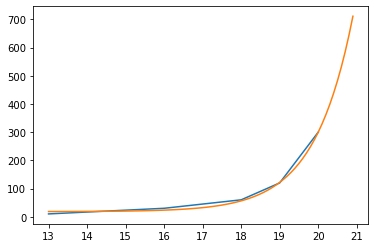

In [79]:
m = np.array([13,16,18,19,20])
mm = np.arange(13,21,0.1)
t = np.array([10,30,60,120,300])
plt.figure()
plt.plot(m,t)
plt.plot(mm,func(mm,popt[0],popt[1],popt[2]))

In [77]:
np.polyfit(10**(m),t, 1)

array([1.01198145e-17, 1.03333012e+02])

In [32]:
test = scrub_look_targets()

In [34]:
test['V         ']

,Target Name,Target Subtype,R.A.,Dec.,V Mag.,"Rate (""/min)",Eccentricity,Period (years),Perihelion Distance (AU),Reciprocal Semi- Major Axis (1/a; AU),Observation Window (for next 90 days)
2,C/2022 S3,NaN,20 11 54.47,-17 37 25.0,20.6,1.29,0.99997,4049000.0,0.8384,NaN,[-----]


In [12]:
looks = pd.read_html('https://neoexchange.lco.global/lookproject/')
active = looks[0]
new = looks[1]

In [19]:
mag_ind = active['V Mag.'].values < 22
active = active.iloc[mag_ind]

In [25]:
x

[12,
 -7,
 25,
 9,
 -21,
 -5,
 -33,
 -33,
 -34,
 19,
 -3,
 -73,
 -18,
 1,
 8,
 23,
 -33,
 -32,
 0,
 18,
 -7,
 -21,
 28,
 0,
 27,
 -32,
 14,
 20,
 7,
 33,
 -50,
 -21,
 26,
 23,
 21,
 -61,
 0,
 -43,
 -17,
 -2,
 2,
 -41,
 -43,
 13,
 -20,
 23,
 -39,
 -22,
 27,
 10,
 29,
 -18,
 -25,
 -71,
 6,
 -43,
 -33,
 -5]

In [13]:

mag_ind = new['V Mag.'].values < 22
new = new.iloc[mag_ind]

In [85]:
active['V Mag.']

0     19.6
1     19.3
2     20.0
3     17.6
4     18.0
5     16.1
6     19.0
7     19.1
8     17.4
9     17.8
10    19.2
11    18.8
12    17.7
13    13.5
14    18.1
15    15.5
17    20.2
18    16.9
19    19.9
20    20.5
21    15.6
22    19.8
24    18.6
25    19.3
26    18.7
27    16.3
28    20.0
29    20.8
30    21.4
31    19.5
33    15.0
35    21.1
36    17.3
37    21.1
38    21.8
39    18.9
40    20.1
41    21.9
42    18.7
43    17.1
45    21.6
46    15.5
48    17.1
49    19.6
50    18.9
53    18.3
54    20.5
56    15.9
58    17.9
59    19.2
60    15.9
61    14.2
62    17.1
63    18.2
64    19.2
65    12.7
66    13.3
68    20.4
Name: V Mag., dtype: float64

In [28]:
looks = pd.read_html('https://neoexchange.lco.global/lookproject/')

In [32]:
for i in range(len(looks[0]['Target Name'])):
    print(looks[0]['Target Name'].iloc[i])

C/2022 U3
2003 CC22
445P
C/2022 S4
C/2022 R6
157P
2022 QE78
285P
73P-BV
73P-BU
73P-JD001
C/2022 L2
395P
C/2022 F1
C/2022 E2
81P
C/2022 A3
C/2021 Y1
108P
A/2021 X2
C/2021 G2
97P
57P
C/2021 T4
C/2021 T2
C/2021 T1
C/2021 S4
382P
C/2021 S1
C/2021 S3
19P
C/2021 R2
P/2021 R1
C/2021 Q4
241P
C/2021 P4
120P
386968
44P
2005 QN173
17P
C/2014 UN271
C/2021 K2
C/2021 K3
99P
22P
2005 XR132
7P
C/2021 E3
C/2021 C4
C/2021 C5
C/2021 A9
C/2021 A1
P/2020 X1
191P
C/2020 U4
C/2020 T2
156P
C/2020 R7
C/2018 F4
C/2020 O2
A/2019 U5
29P
C/2019 L3
C/2019 F1
C/2019 E3
2060
C/2017 K2
73P
45P
67P


In [39]:
look['active']['V Mag.']

1     19.6
2     19.5
4     19.6
5     17.6
6     17.9
7     16.1
8     19.4
9     19.5
10    17.4
12    19.3
13    18.8
14    17.6
15    13.4
16    17.9
19    20.3
20    16.8
21    19.9
23    15.5
24    20.0
27    19.3
29    16.2
30    20.1
32    21.5
35    15.2
37    21.0
41    18.9
42    20.2
43    21.9
44    18.7
45    17.3
47    21.6
48    15.5
50    17.1
51    19.6
52    19.0
54    21.9
56    20.6
58    16.0
61    19.2
63    14.2
64    17.2
65    18.2
66    19.3
67    12.7
68    13.7
70    20.4
Name: V Mag., dtype: float64

In [25]:
from astroquery.jplhorizons import Horizons
obj = Horizons(id='20065803', location='474',
               epochs={'start':'2022-11-12', 'stop':'2022-11-13',
                       'step':'10m'})
eph = obj.ephemerides()
print(eph)

           targetname               datetime_str   ...  PABLon  PABLat
              ---                       ---        ...   deg     deg  
-------------------------------- ----------------- ... ------- -------
Didymos (system barycenter) (200 2022-Nov-12 00:00 ... 89.0397 -5.0869
Didymos (system barycenter) (200 2022-Nov-12 00:10 ... 89.0446 -5.0841
Didymos (system barycenter) (200 2022-Nov-12 00:20 ... 89.0496 -5.0813
Didymos (system barycenter) (200 2022-Nov-12 00:30 ... 89.0546 -5.0786
Didymos (system barycenter) (200 2022-Nov-12 00:40 ... 89.0596 -5.0758
Didymos (system barycenter) (200 2022-Nov-12 00:50 ... 89.0645  -5.073
Didymos (system barycenter) (200 2022-Nov-12 01:00 ... 89.0696 -5.0702
                             ...               ... ...     ...     ...
Didymos (system barycenter) (200 2022-Nov-12 23:00 ... 89.7068 -4.7021
Didymos (system barycenter) (200 2022-Nov-12 23:10 ... 89.7116 -4.6994
Didymos (system barycenter) (200 2022-Nov-12 23:20 ... 89.7164 -4.6968
Didymo

In [32]:
t = eph.to_pandas()
air_ind = t['airmass'].values < 2.5
t = t.iloc[air_ind]

In [28]:
t.keys()

Index(['targetname', 'datetime_str', 'datetime_jd', 'solar_presence', 'flags',
       'RA', 'DEC', 'RA_app', 'DEC_app', 'RA_rate', 'DEC_rate', 'AZ', 'EL',
       'AZ_rate', 'EL_rate', 'sat_X', 'sat_Y', 'sat_PANG', 'siderealtime',
       'airmass', 'magextinct', 'V', 'surfbright', 'illumination',
       'illum_defect', 'sat_sep', 'sat_vis', 'ang_width', 'PDObsLon',
       'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang', 'SubSol_dist',
       'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r', 'r_rate', 'delta',
       'delta_rate', 'lighttime', 'vel_sun', 'vel_obs', 'elong', 'elongFlag',
       'alpha', 'lunar_elong', 'lunar_illum', 'sat_alpha', 'sunTargetPA',
       'velocityPA', 'OrbPlaneAng', 'constellation', 'TDB-UT', 'ObsEclLon',
       'ObsEclLat', 'NPole_RA', 'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime',
       'earth_lighttime', 'RA_3sigma', 'DEC_3sigma', 'SMAA_3sigma',
       'SMIA_3sigma', 'Theta_3sigma', 'Area_3sigma', 'RSS_3sigma', 'r_3sigma',
       'r_rate_3sigma', 'SBand

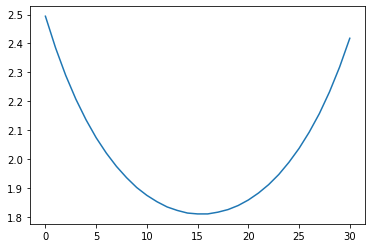

In [33]:
plt.figure()
plt.plot(t['airmass'].values)

In [34]:
t['datetime_str']

89     2022-Nov-12 14:50
90     2022-Nov-12 15:00
91     2022-Nov-12 15:10
92     2022-Nov-12 15:20
93     2022-Nov-12 15:30
94     2022-Nov-12 15:40
95     2022-Nov-12 15:50
96     2022-Nov-12 16:00
97     2022-Nov-12 16:10
98     2022-Nov-12 16:20
99     2022-Nov-12 16:30
100    2022-Nov-12 16:40
101    2022-Nov-12 16:50
102    2022-Nov-12 17:00
103    2022-Nov-12 17:10
104    2022-Nov-12 17:20
105    2022-Nov-12 17:30
106    2022-Nov-12 17:40
107    2022-Nov-12 17:50
108    2022-Nov-12 18:00
109    2022-Nov-12 18:10
110    2022-Nov-12 18:20
111    2022-Nov-12 18:30
112    2022-Nov-12 18:40
113    2022-Nov-12 18:50
114    2022-Nov-12 19:00
115    2022-Nov-12 19:10
116    2022-Nov-12 19:20
117    2022-Nov-12 19:30
118    2022-Nov-12 19:40
119    2022-Nov-12 19:50
Name: datetime_str, dtype: object